In [1]:
from gala import evaluate as ev, imio, viz
import numpy as np
from skimage.util import regular_seeds
from skimage import morphology as morph
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage import measure
import os
import sys

In [2]:
raw, gt = imio.read_cremi("../research_project_files/Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])

In [3]:
raw = np.max(raw) - raw
raw = raw[raw.shape[0]//2]
gt = gt[gt.shape[0]//2]
gt_2d = measure.label(gt)
seeds = regular_seeds(raw.shape, np.random.randint(800, 1500))
automated_seg = morph.watershed(raw, seeds, compactness=0.001)

In [7]:
def view_splits(gt, automated_seg, num_elem=4):
        """Generates a clickable image of the gt seg
        and upon click, shows the largest comps
        in the automated seg that correspond to the clicked
        comp.
        Parameters
            gt: nd-array with shape M*N.
                This corresponds to the 'ground truth'.
            auto: nd-array with same shape as gt. This
                corresponds to the automated segmentation.
            num_elem: Int, optional.
                This parameter determines the number of comps
                shown upon click. Set to output '4' by default.
        returns:
            A panel with three images - the third corresponds to the
            components that are the worst false splits in the automated
            segmentation that corresponds to the components clicked in
            the first window.
        """

        # Uncomment next line if running this function in Ipython:
        % matplotlib auto


        if gt.shape != automated_seg.shape:
            return "Input arrays are not of the same shape."
        elif (type(gt) or type(automated_seg)) != np.ndarray:
            return "Input arrays not of valid type."
        else:
            cont = ev.contingency_table(automated_seg, gt)
            ii1, err1 = ev.sorted_vi_components(automated_seg, gt)[0:2]
            idxs = np.argsort(ii1)
            err_unsorted = err1[idxs]
            err_img = err_unsorted[gt]
            plt.interactive = False
            fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
            plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
            ax[0,0].imshow(raw, cmap='gray')
            viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0,0])
            ax[0,1].imshow(raw, cmap='gray')
            viz.imshow_magma(err_img, alpha=0.4, axis=ax[0,1])
            ax[1,0].imshow(raw, cmap='gray')
            viz.imshow_rand(gt, alpha=0.4, axis=ax[1,0])
            ax[1,1].imshow(raw, cmap='gray')
            axes_image = viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[1,1])
            ax[0,0].set_title("Automated seg: click to show worst splits below. ")
            ax[0,1].set_title("Ground truth: Colored by level of VI error.")
            ax[1,0].set_title("Ground truth with randomised colormap. ")
            ax[1,1].set_title("Worst split comps from the automated seg in the gt. ")

            def onpress(event): 
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(gt[y, x], cont, axis=1, num_elems=None)
                new_seg = np.zeros_like(automated_seg)
                factor = (automated_seg.max() // num_elem)
                lim = 0.0
                for i, (j, k, z) in enumerate(comps):
                    lim += k
                    if z < 0.02:
                        continue
                    new_seg += (automated_seg == j) * ((i + 1) * factor)
                    if lim >= 0.95:
                        break
                axes_image.set_array(new_seg)
                fig.canvas.draw()

            fig.canvas.mpl_connect('button_press_event', onpress)
            plt.show()

In [8]:
plt.clf()
view_splits(gt, automated_seg, num_elem=30)

Using matplotlib backend: Qt5Agg


In [7]:
def view_merges(gt, automated_seg, num_elem=4):
        """Generates a click-able image of the auto seg - upon click of
        the auto seg, shows the largest comps of the gt that corresponds
        to the worst false merges made in the automatic seg at the approx.
        same location of the click.
        Parameters
        gt: nd-array with shape M*N.
            This corresponds to the 'ground truth'.
        auto: nd-array with same shape as gt. This
            corresponds to the automated segmentation.
        num_elem: Int, optional.
            This parameter determines the number of comps
            shown upon click. Set to output '4' by default.
        returns:
        A panel with four images - the bottom right corresponds to the
        components that are the worst false merges in the automated
        segmentation that corresponds to the components clicked in
        the first window.
        """
        %matplotlib auto
        if gt.shape != automated_seg.shape:
            return "Input arrays are not of the same shape."
        elif (type(gt) or type(automated_seg)) != np.ndarray:
            return "Input arrays not of valid type."
        else:
            cont = ev.contingency_table(automated_seg, gt)
            ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
            idxs = np.argsort(ii2)
            err_unsorted = err2[idxs]
            err_img = err_unsorted[automated_seg]
            plt.interactive = False
            fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
            plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
            ax[0,0].imshow(raw, cmap='gray')
            viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 0])
            ax[0,1].imshow(raw, cmap='gray')
            viz.imshow_magma(err_img, alpha=0.4, axis=ax[0, 1])
            ax[1,0].imshow(raw, cmap='gray')
            viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 0])
            ax[1,1].imshow(raw, cmap='gray')
            axes_image = viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 1])
            ax[0, 0].set_title("Automated seg: click to show worst splits below. ")
            ax[0, 1].set_title("Ground truth: Colored by level of VI error.")
            ax[1, 0].set_title("Ground truth with default cm. ")
            ax[1, 1].set_title("Worst merge comps from the automated seg in the gt. ")

            def onpress(event):
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(automated_seg[y, x], cont, axis=0, num_elems=num_elem)
                new_seg = np.zeros_like(gt.astype('float64'))
                factor = (gt.max() // num_elem)
                lim = 0.0
                for i, (j,k, z) in enumerate(comps):
                    lim +=k
                    if z < 0.02:
                        continue
                    new_seg += (gt == j) * ((i + 1) * factor)
                axes_image.set_array(new_seg)
                fig.canvas.draw()

            fig.canvas.mpl_connect('button_press_event', onpress)
            plt.ioff()
            plt.show()

In [8]:
view_merges(gt, automated_seg)

Using matplotlib backend: Qt5Agg


In [4]:
automated_colorised = plt.cm.viridis(automated_seg)
automated_colorised[...,3] = 0.3
# raw = np.max(raw) - raw


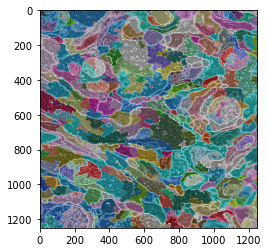

In [7]:
fig1, ax1 = plt.subplots(ncols=1, nrows=1)

ax1.imshow(raw, cmap='gray')
viz.imshow_rand(automated_seg, alpha=0.4, axis=ax1)

In [54]:
cont = ev.contingency_table(automated_seg, gt)
ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
idxs = np.argsort(ii2)
err_unsorted = err2[idxs]
idxs

array([1039, 1216, 1217, ...,  901, 1365, 1600])

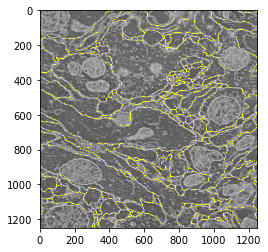

In [13]:
%matplotlib inline
fig2, ax2 = plt.subplots(ncols=1, nrows=1)
ax2.imshow(automated_seg, alpha=0.4)
viz.imshow_rand(mark_boundaries(raw, gt), axis=ax2)

In [6]:
%matplotlib auto
view_merges(gt, automated_seg)

Using matplotlib backend: Qt5Agg


In [9]:
def view_all(gt, automated_seg, num_elem=4):
        """Generates a click-able image of the auto seg - upon click of
        the auto seg, shows the largest comps of the gt that corresponds
        to the worst false merges made in the automatic seg at the approx.
        same location of the click.
        Parameters
        gt: nd-array with shape M*N.
            This corresponds to the 'ground truth'.
        auto: nd-array with same shape as gt. This
            corresponds to the automated segmentation.
        num_elem: Int, optional.
            This parameter determines the number of comps
            shown upon click. Set to output '4' by default.
        returns:
        A panel with four images - the bottom right corresponds to the
        components that are the worst false merges in the automated
        segmentation that corresponds to the components clicked in
        the first window.
        """
        %matplotlib auto
        if gt.shape != automated_seg.shape:
            return "Input arrays are not of the same shape."
        elif (type(gt) or type(automated_seg)) != np.ndarray:
            return "Input arrays not of valid type."
        else:
            cont = ev.contingency_table(automated_seg, gt)
            ii2, err2 = ev.sorted_vi_components(automated_seg, gt)[2:4]
            idxs = np.argsort(ii2)
            err_unsorted = err2[idxs]
            err_img = err_unsorted[automated_seg]
            plt.interactive = False
            fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
            plt.setp(ax.flat, aspect=1.0, adjustable='box-forced')
            ax[0,0].imshow(raw, cmap='gray')
            viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0, 0])
            ax[0,1].imshow(raw, cmap='gray')
            axes_image_1 = viz.imshow_rand(automated_seg, alpha=0.4, axis=ax[0,1])
            ax[1,0].imshow(raw, cmap='gray')
            viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 0])
            ax[1,1].imshow(raw, cmap='gray')
            axes_image = viz.imshow_rand(gt, alpha=0.4, axis=ax[1, 1])
            ax[0, 0].set_title("Automated seg: click to show worst splits below. ")
            ax[0, 1].set_title("Ground truth: Colored by level of VI error.")
            ax[1, 0].set_title("Ground truth with default cm. ")
            ax[1, 1].set_title("Worst merge comps from the automated seg in the gt. ")

            def onpress_m(event):
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(automated_seg[y, x], cont, axis=0, num_elems=num_elem)
                new_seg = np.zeros_like(gt.astype('float64'))
                factor = (gt.max() // num_elem)
                lim = 0.0
                for i, (j,k, z) in enumerate(comps):
                    lim +=k
                    if z < 0.02:
                        continue
                    new_seg += (gt == j) * ((i + 1) * factor)
                axes_image_1.set_array(new_seg)
                fig.canvas.draw()
                
            def onpress_s(event): 
                if event.button != 1:
                    return
                x, y = int(event.xdata), int(event.ydata)
                comps = ev.split_components(gt[y, x], cont, axis=1, num_elems=None)
                new_seg = np.zeros_like(automated_seg)
                factor = (automated_seg.max() // num_elem)
                lim = 0.0
                for i, (j, k, z) in enumerate(comps):
                    lim += k
                    if z < 0.02:
                        continue
                    new_seg += (automated_seg == j) * ((i + 1) * factor)
                    if lim >= 0.95:
                        break
                axes_image.set_array(new_seg)
                fig.canvas.draw()

            fig.canvas.mpl_connect('button_press_event', onpress_m)
            fig.canvas.mpl_connect('button_press_event', onpress_s)
            plt.ioff()
            plt.show()

In [10]:
view_all(gt, automated_seg)

Using matplotlib backend: Qt5Agg
